In [18]:
import io
import os
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import itertools
import collections
import random
import tensorflow as tf

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support 

%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

MSLR-WEB10K
MSLR-WEB30K
Ranklib



In [2]:
def load_txt(foldDir,foldsize,foldnum):
    corpusDir = os.path.join('%s%s' % (inputDir,  os.listdir(foldDir)[foldsize]))
    dataDir = os.path.join('%s/%s' % (corpusDir, os.listdir(corpusDir)[foldnum]))
    trainDir = os.path.join('%s/%s' % (dataDir, "train.txt"))
    testDir = os.path.join('%s/%s' % (dataDir, "test.txt"))
    validDir = os.path.join('%s/%s' % (dataDir, "vali.txt"))
    return [trainDir,testDir ,validDir]

# Dropping column with 100% nan values (parsing problem probably)
def drop_col(df):
    df.drop(df.columns[-1], axis=1, inplace=True)

# Cleaning values
def split_semicolon(df):
    # removes string naming pattern '*:' from values
    for col in range(1,len(df.columns)):
        df.loc[:,col] = df.loc[:,col].apply(lambda x: str(x).split(':')[1])
    df.columns = ['rel', 'qid'] + [str(x) for x in range(1,137)] # renaming cols

In [3]:
# inputDir = "../input/"
# dataDir = load_txt(inputDir,1,1)

# for dataset in dataDir:
#     data = pd.read_csv(dataset, sep=" ", header = None)
#     drop_col(data)
#     split_semicolon(data)
#     data.to_csv(dataset[0:-4]+'.csv')

In [4]:
def load_csv(foldDir,foldsize,foldnum):
    corpusDir = os.path.join('%s%s' % (inputDir,  os.listdir(foldDir)[foldsize]))
    dataDir = os.path.join('%s/%s' % (corpusDir, os.listdir(corpusDir)[foldsize]))
    trainDir = os.path.join('%s/%s' % (dataDir, "train.csv"))
    testDir = os.path.join('%s/%s' % (dataDir, "test.csv"))
    validDir = os.path.join('%s/%s' % (dataDir, "vali.csv"))
    return [trainDir,testDir ,validDir]


# input data
inputDir = "../input/"
dataDir = load_csv(inputDir,1,1)

trainset = pd.read_csv(dataDir[0])
trainset.drop(trainset.columns[0], axis=1, inplace=True)
testset  = pd.read_csv(dataDir[1])
testset.drop(testset.columns[0], axis=1, inplace=True)
validset = pd.read_csv(dataDir[2])
validset.drop(validset.columns[0], axis=1, inplace=True)



In [5]:
# sort data by qid and rel

trainset_sort = trainset.sort_values(by=['qid','rel'],ascending=False)
testset_sort = testset.sort_values(by=['qid','rel'],ascending=False)
validset_sort = validset.sort_values(by=['qid','rel'],ascending=False)

# generate train set, valid set, test set

y_train = trainset_sort['rel'].values
X_train = trainset_sort.drop(['rel','qid'],axis=1).values

y_valid = validset_sort['rel'].values
X_valid = validset_sort.drop(['rel','qid'],axis=1).values

y_test = testset_sort['rel'].values
X_test = testset_sort.drop(['rel','qid'],axis=1).values

In [17]:
AdaBoost = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
%time AdaBoost.fit(X_train,y_train)
joblib.dump(AdaBoost, 'AdaBoostBase.pkl') 

CPU times: user 5min 48s, sys: 4.16 s, total: 5min 52s
Wall time: 5min 54s


['AdaBoostBase.pkl']

In [97]:
# AdaBoostTree = AdaBoostClassifier( DecisionTreeClassifier(max_depth=5, min_samples_leaf=1),
#                                     algorithm='SAMME.R',
#                                     learning_rate=0.1, 
#                                     n_estimators=200, 
#                                     random_state=None,)

# %time AdaBoostTree.fit(X_train,y_train)
# joblib.dump(AdaBoostTree, 'AdaBoostTree_1.pkl') 

CPU times: user 2h 28min 32s, sys: 1min 9s, total: 2h 29min 41s
Wall time: 3h 31min 2s


['AdaBoostTree_1.pkl']

In [ ]:
## prediction accuracy on validation set and test set
ranker = rankerX
%time score = ranker.score(X_valid, y_valid)
print ('The socre on validation set : '  + str(score))
%time score = ranker.score(X_test, y_test)
print ('The socre on test set : '  + str(score))

y_valid_predict = ranker.predict(X_valid)
y_test_predict = ranker.predict(X_test)

In [25]:
rankerX = joblib.load('AdaBoostTree.pkl')
## prediction accuracy on validation set and test set
ranker = rankerX

%time score = ranker.score(X_test, y_test)
print ('The socre on test set : '  + str(score))

y_test_predict = ranker.predict(X_test)

CPU times: user 14.3 s, sys: 3.4 s, total: 17.7 s
Wall time: 18.3 s
The socre on test set : 0.56399650548


## Learning to Rank Evaluation Metrics


## Confusion matrix¶

Testset : Confusion matrix, without normalization
[[100993  23169    581      5     36]
 [ 43580  33024   1230     11     51]
 [ 14258  16092   2052     14     43]
 [  1803   2080    515     10     42]
 [   722    953    100     19    138]]
fscore: [ 0.71  0.43  0.11  0.    0.12]


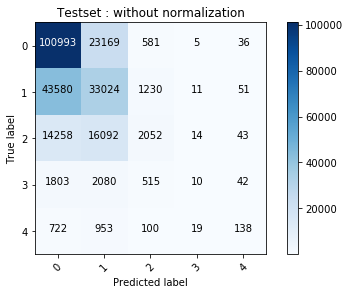

In [26]:
def plot_confusion_matrix(cm, classes,dataset,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(dataset + ' : ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(dataset + " : Normalized confusion matrix" )
    else:
        print(dataset + ' : Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def CM_metric(target,predict,name):   
    cnf_matrix = confusion_matrix(target,predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes='01234',dataset = name, normalize=False,
                          title='without normalization')
    

CM_metric(y_test,y_test_predict,'Testset') 
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_test_predict)
print('fscore: {}'.format(fscore))

  ##  Normalized Discounted Cumulative Gain （NDCG）

In [27]:
# Normalized Discounted Cumulative Gain

def NDCG_metric(dataset,predict,target,position):
    Result_predict = collections.defaultdict(int)
    Result_target = collections.defaultdict(int)
    Result_normalization = collections.defaultdict(int)

    index = 0
    
    qid = qid_old = dataset['qid'][0]
    for i in range(len(dataset)): 
        qid = dataset['qid'][i]
        
        if qid != qid_old:
            index = 0
        
        if index < position:
            Result_predict[qid] += (np.power(2, predict[i])-1)/(np.log2(index+2))
            Result_target[qid] += (np.power(2,  target[i])-1)/(np.log2(index+2))
            index += 1
            qid_old = qid
       
    for key in Result_predict.keys():
        Result_normalization[key] = Result_predict[key]/Result_target[key] if Result_target[key] > 0 else 0
     
    data = [Result_predict.values(),Result_target.values(),Result_normalization.values()]
    df = pd.DataFrame(data,index=['predict','target','NDCG'],columns=Result_predict.keys())
    return df.T

order = 1
%time NDCG_test = NDCG_metric(testset,y_test_predict,y_test,order)
score = np.mean(NDCG_test['NDCG'])
print ('The NDCG socre on test set : '  + str(score))
order = 3
%time NDCG_test = NDCG_metric(testset,y_test_predict,y_test,order)
score = np.mean(NDCG_test['NDCG'])
print ('The NDCG socre on test set : '  + str(score))
order = 10
%time NDCG_test = NDCG_metric(testset,y_test_predict,y_test,order)
score = np.mean(NDCG_test['NDCG'])
print ('The NDCG socre on test set : '  + str(score))

CPU times: user 5.31 s, sys: 55.1 ms, total: 5.37 s
Wall time: 5.48 s
The NDCG socre on test set : 0.20169999999999985
CPU times: user 5.51 s, sys: 31.5 ms, total: 5.54 s
Wall time: 5.64 s
The NDCG socre on test set : 0.20424559267124923
CPU times: user 5.98 s, sys: 53.9 ms, total: 6.03 s
Wall time: 6.37 s
The NDCG socre on test set : 0.25335356287303734


## Mean Average Precision (MAP)

In [28]:
def AP_metric(dataset,predict,target):

    Result_K = collections.defaultdict(int)
    Result_APK = collections.defaultdict(int)
    Result_APN = collections.defaultdict(int)
    
    index = 0
    
    qid = qid_old = dataset['qid'][0]
    for i in range(len(dataset)): 
        qid = dataset['qid'][i]
        
        if qid != qid_old:
            index = 0
         
        Result_K[qid] += 1 if predict[i] == target[i] else 0
        Result_APK[qid] += Result_K[qid]/(index+1) if predict[i] == target[i] else 0
        index += 1
        qid_old = qid 
      
    for key in Result_APK.keys():
        Result_APN[key] = Result_APK[key]/Result_K[key] if Result_K[key] > 0 else 0

    data = [Result_APN.values(),Result_APK.values(),Result_K.values()]
    df = pd.DataFrame(data,index=['APN','APK','K'],columns=Result_APN.keys())
    return df.T

%time MAP_valid = AP_metric(testset,y_test_predict,y_test)
score = np.mean(MAP_valid['APN'])
print ('The MAP socre on Test set : ' + str(score))

CPU times: user 6.15 s, sys: 44.3 ms, total: 6.19 s
Wall time: 6.43 s
The MAP socre on Test set : 0.6121058666284603
